In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
import scipy.ndimage.filters as filters 
import matplotlib.ticker as ticker

file_path_500 = '/beegfs/desy/user/korcariw/multiRes_CaloClouds/dataset/showers/photons_10_100GeV_10bins_showers_train.h5'
file_path_1700 = '/beegfs/desy/user/korcariw/CaloClouds/dataset/showers/photons_10_100GeV_float32_sorted_train.h5'

In [2]:
""" 
This script contains all functions that are used to create all plots in the distance correlation network.
"""
plt.rcParams["font.family"] = "serif"
fig_width_pt = 437.46118  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
rectangular_fig_size = [fig_width,fig_height]
quadratic_fig_size = [fig_width,fig_width]

In [4]:
    with h5py.File(file_path_500, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        print(dataset_genE.shape)

(760000, 1)


In [3]:
def plot_shower_data(file_path, filter_energy=60, threshold_energy=5):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
        #extracting the size of the showers
        size_of_event = len(data_showers[0])
        
        # Filter the data based on energy range
        is_in_range = np.abs(energy_total - filter_energy) <= threshold_energy
        selected_indices = np.where(is_in_range)[0]
        filtered_data = data_showers[selected_indices]
        
        # Extract coordinates and energies
        x_complete, y_complete, z_complete, energy_xyz_complete = [filtered_data[:, :, i] for i in range(4)]
        x = x_complete[x_complete != 0]
        y = y_complete[y_complete != 0]
        z = z_complete[z_complete != 0]
        xyz_bin_min = min(x)
        xyz_bin_max = max(x)+2
        
        energy_xyz = energy_xyz_complete[energy_xyz_complete > 0]
        
        # Convert energy to MeV
        energy_total_mev = energy_total * 1000
        
        # Plotting the distributions
        fig = plt.figure(figsize=(18, 12), facecolor='white')
        fig.suptitle(f'Projected {filter_energy}GeV Showers', fontsize=30)
        gs = GridSpec(2, 3)

        # Energy Histogram
        ax0 = fig.add_subplot(gs[0])
        ax0.set_title('Visible Energy')
        ax0.hist(energy_xyz, bins=np.logspace(np.log(0.1), np.log(max(energy_xyz)), 150, base=np.e), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax0.set_xlabel('Visible energy (MeV)')
        ax0.set_ylabel('a.u.')
        ax0.set_xscale('log')
        ax0.set_yscale('log')

        # Energy Sum Histogram
        ax1 = fig.add_subplot(gs[1])
        ax1.set_title('Energy Sum')
        ax1.hist(energy_xyz_complete.reshape(-1, size_of_event).sum(-1), bins=50, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax1.set_xlabel('Visible energy sum (MeV)')
        ax1.set_ylabel('a.u.')

        # Number of Hits Histogram
        ax2 = fig.add_subplot(gs[2])
        ax2.set_title('Number of Hits')
        n_hits = (energy_xyz_complete != 0).reshape(-1, size_of_event).sum(axis=1)
        ax2.hist(n_hits, bins=50, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax2.set_xlabel('n_hits')
        ax2.set_ylabel('a.u.')

        step =  math.ceil(xyz_bin_max/11)
        # X Distribution
        ax3 = fig.add_subplot(gs[3])
        ax3.set_title('[x] distribution')
        ax3.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax3.hist(x, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax3.set_xlabel('[x]')
        ax3.set_ylabel('Number of hits')
        ax3.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Y Distribution
        ax4 = fig.add_subplot(gs[4])
        ax4.set_title('[y] distribution')
        ax4.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax4.hist(y, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax4.set_xlabel('[y]')
        ax4.set_ylabel('Number of hits')
        ax4.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Z Distribution
        ax5 = fig.add_subplot(gs[5])
        ax5.set_title('[z] distribution')
        ax5.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax5.hist(z, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax5.set_xlabel('[z]')
        ax5.set_ylabel('Number of hits')
        ax5.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        fig.tight_layout()
        plt.show()
        fig.savefig(f'./plots/{filter_energy}GeV_showers_{size_of_event}_points.png')


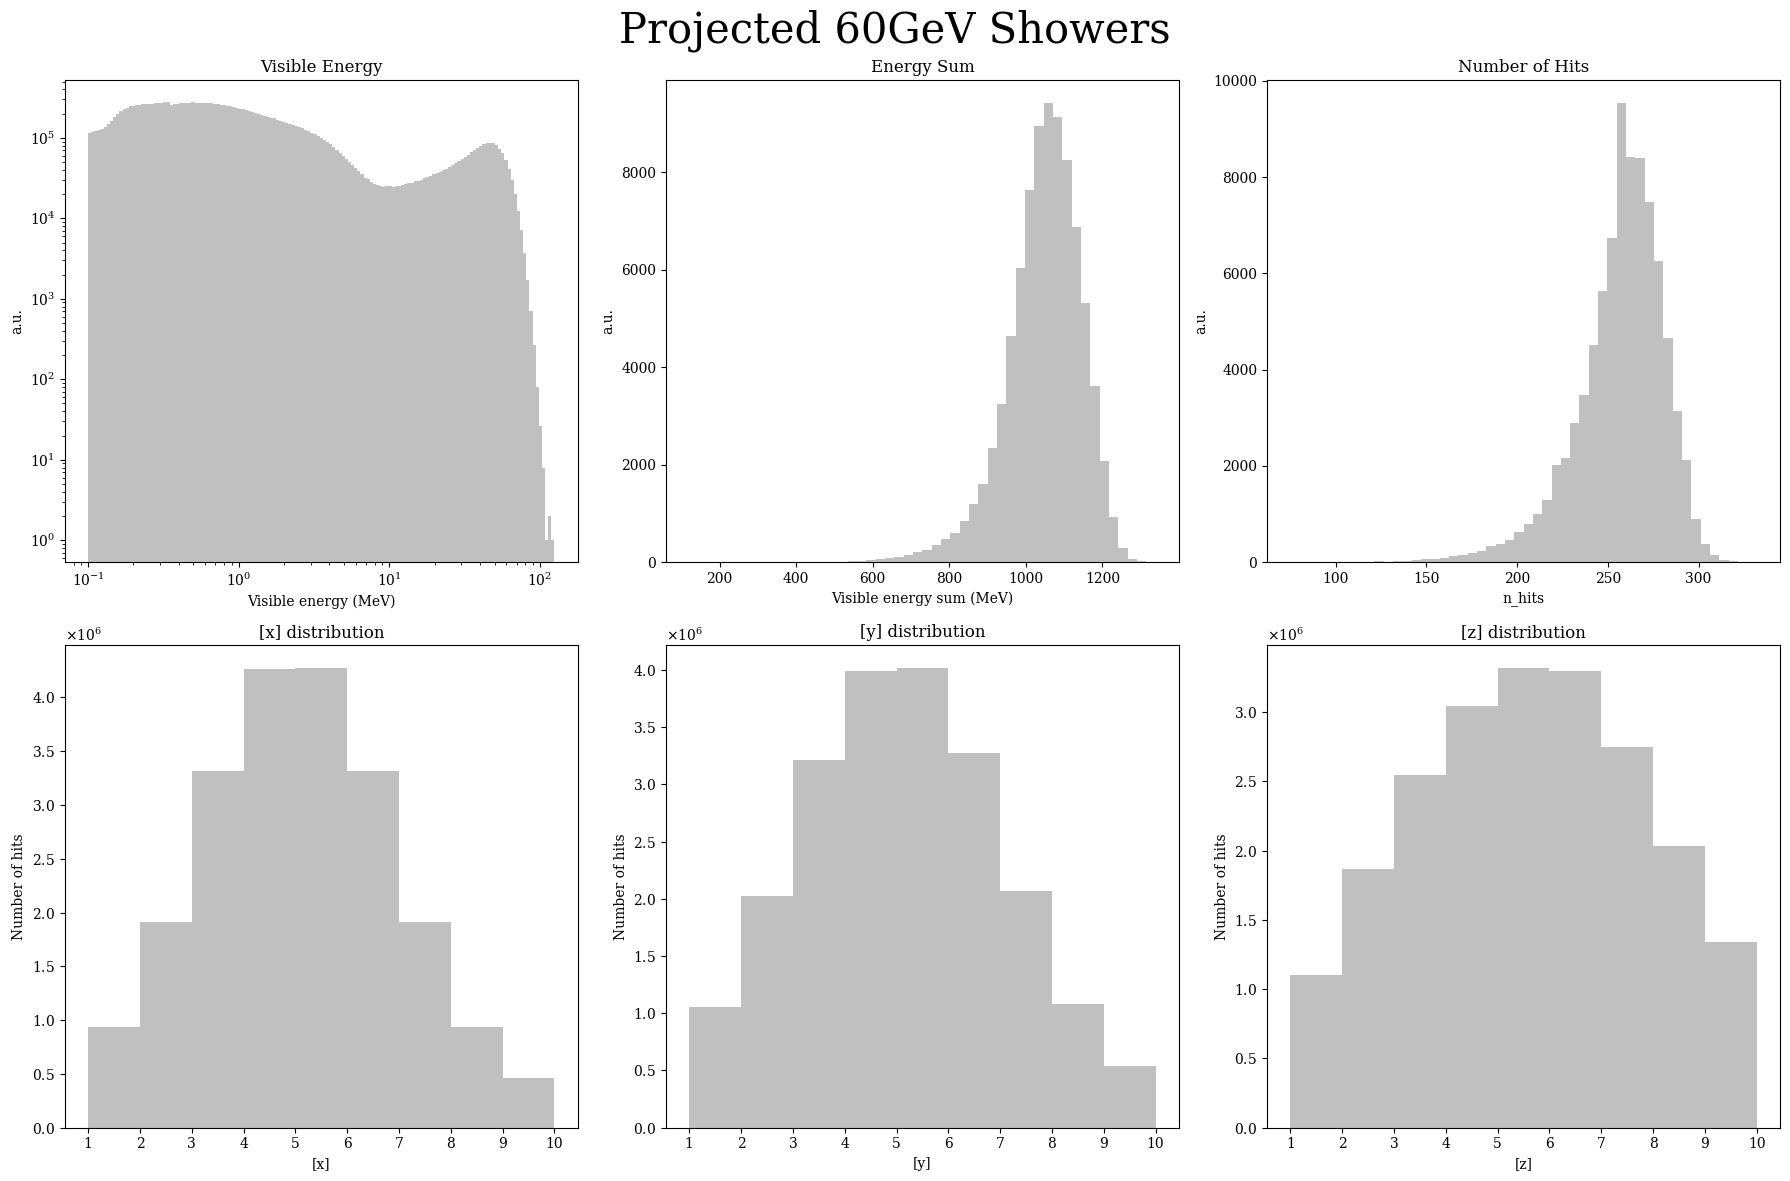

In [4]:
#Plot for the 500 event showers

plot_shower_data(file_path_500)

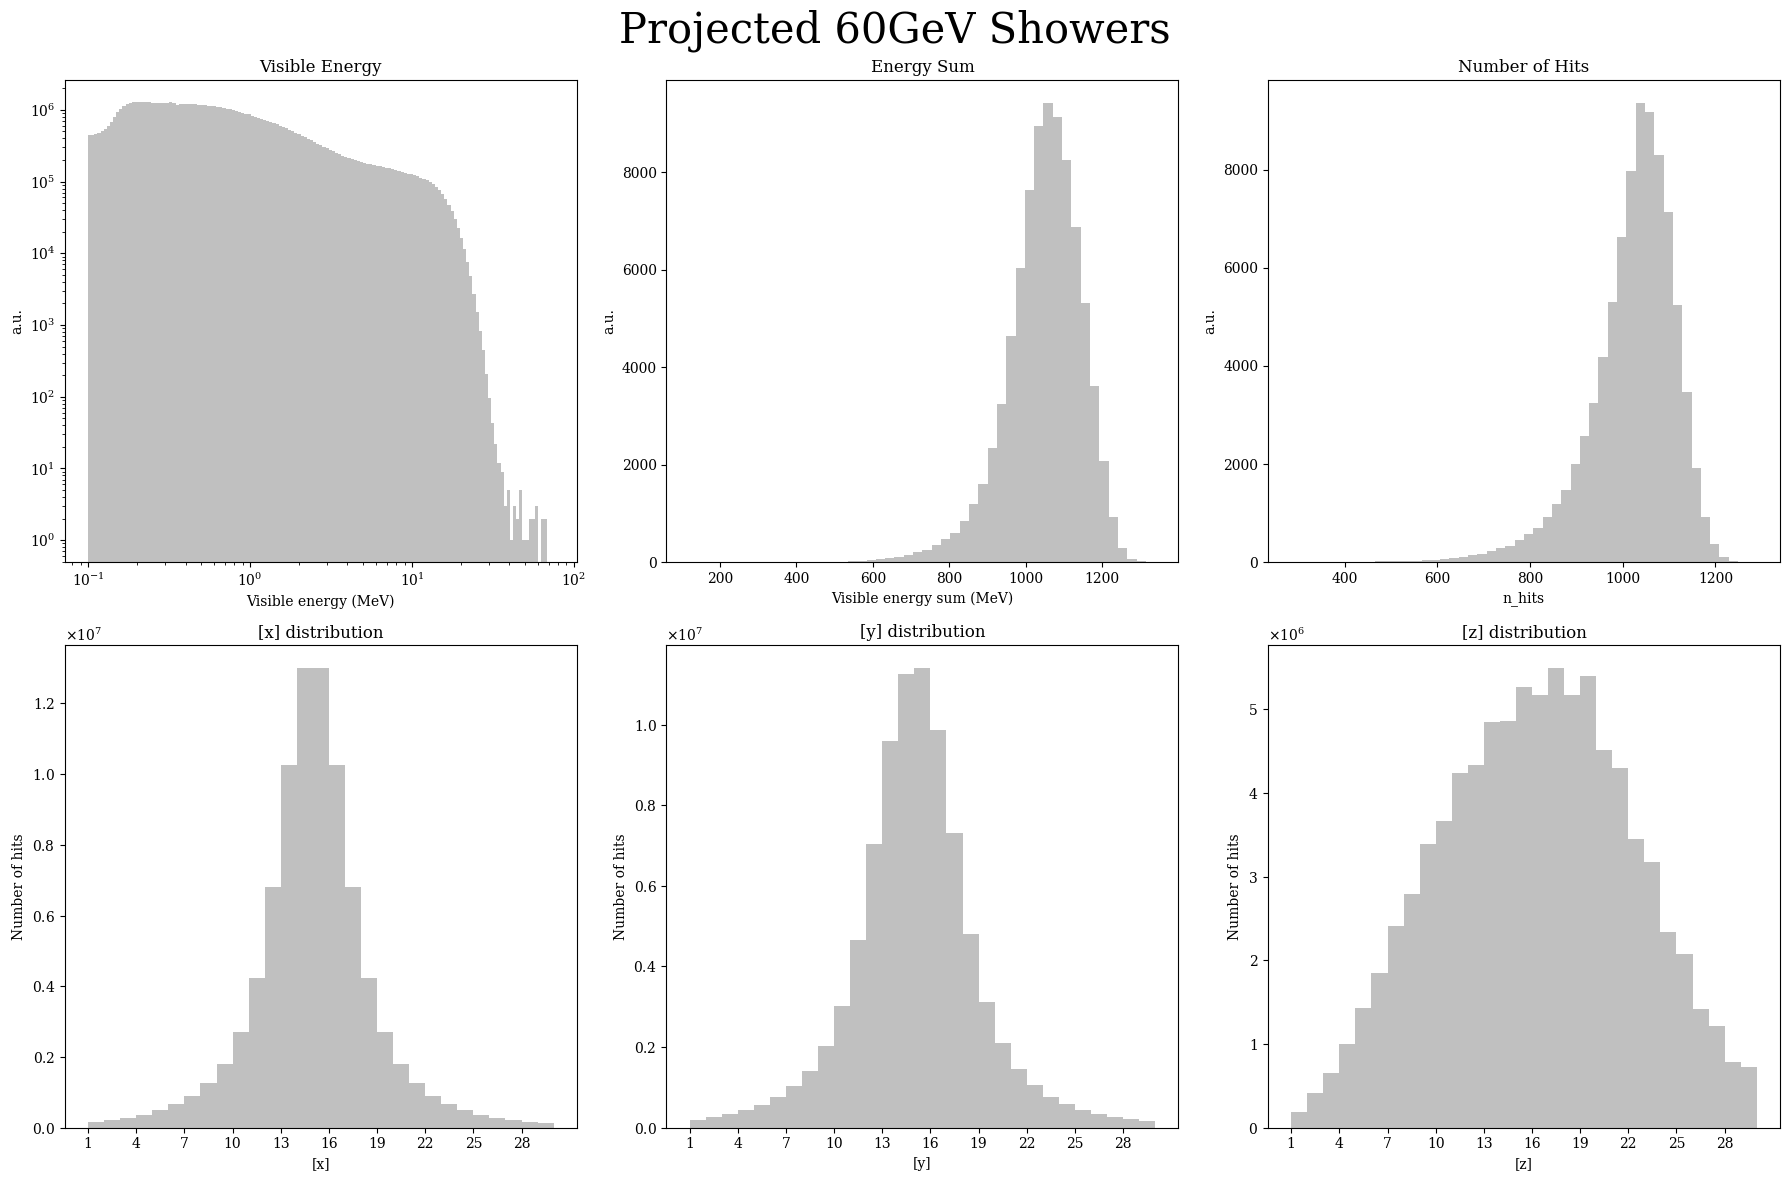

In [5]:
#Plot for the 1700 event showers
plot_shower_data(file_path_1700)


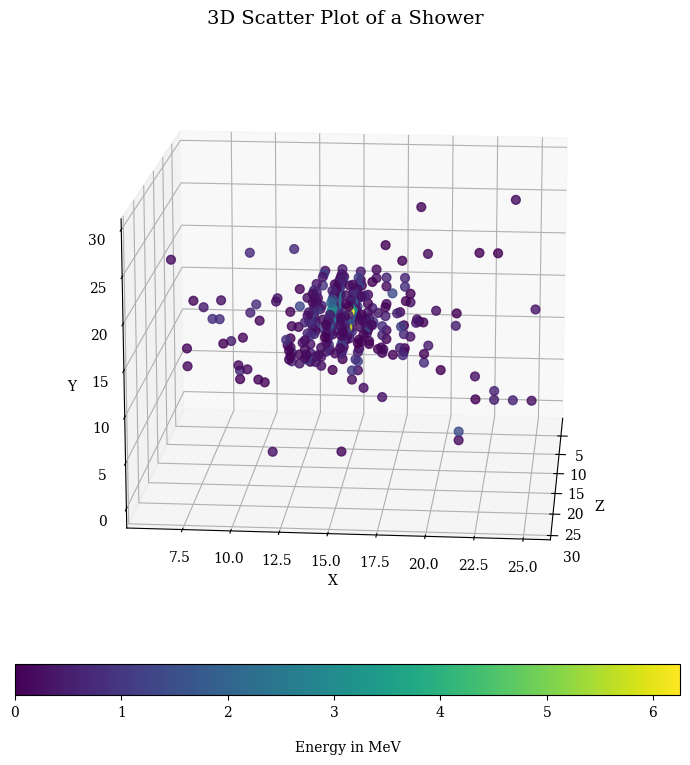

In [123]:
def threedplot(file_path,event_number):
    with h5py.File(file_path, 'r') as f:

        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
    shower = data_showers[event_number]
    
    x, y, z, e = [shower[ :, i] for i in range(4)]
    x = x[e != 0]
    y = y[e != 0]
    z = z[e != 0]
    e = e[e != 0]


    # Assuming you have your data arrays (x, y, z, e)  

    fig = plt.figure(figsize=(7, 8))  # Slightly larger figure size
    grid = plt.GridSpec(2, 1, height_ratios=[20, 1]) 

    # Create 3D scatter plot
    ax = fig.add_subplot(grid[0], projection='3d')
    scatter = ax.scatter(z, x, y, c=e, cmap='viridis', s=40, alpha=0.8)  

    # Descriptive labels
    ax.set_xlabel('Z') 
    ax.set_ylabel('X')
    ax.set_zlabel('Y')

    ax.view_init(elev=15, azim=5)  

    # Create colorbar
    cax = fig.add_subplot(grid[1]) 

    # Get the current position of the colorbar axes
    norm = plt.Normalize(0, e.max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([]) 

    cbar = fig.colorbar(sm, cax=cax, format=ticker.ScalarFormatter(useMathText=True), 
                        orientation='horizontal')  # Horizontal colorbar
    cbar.set_label('Energy in MeV', rotation=0, labelpad=15)  # Descriptive label

    # Title and layout
    fig.suptitle('3D Scatter Plot of a Shower',fontsize=14,x=0.5,y=0.95)  
    fig.tight_layout()  # More precise layout adjustments

    fig.savefig('./plots/threedplot_front1700.png')  
threedplot(file_path_1700,7000)


In [5]:
def plot_shower_heatmap(file_path, filter_energy=60, threshold_energy=5):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
    #extracting the size of the showers
    size_of_event = len(data_showers[0])
    
    # Filter the data based on energy range
    is_in_range = np.abs(energy_total - filter_energy) <= threshold_energy
    selected_indices = np.where(is_in_range)[0]
    filtered_data = data_showers[selected_indices]
    
    # Extract coordinates and energies
    x, y, z, energy = [filtered_data[:, :, i] for i in range(4)]
    
    nonzero_mask = (energy != 0)
    x = x[nonzero_mask]
    y = y[nonzero_mask]
    z = z[nonzero_mask]
    energy = energy[nonzero_mask]
    x,y,z,energy = x.flatten(), y.flatten(), z.flatten(), energy.flatten()
    
    heatmap_xy = np.zeros((int(max(y)+1),int(max(y)+1)))
    heatmap_zy = np.zeros((int(max(y)+1),int(max(y)+1)))
    heatmap_zx = np.zeros((int(max(y)+1),int(max(y)+1)))
    count_xy = np.zeros_like(heatmap_xy)
    count_zy = np.zeros_like(heatmap_zy)
    count_zx = np.zeros_like(heatmap_zx)
    # Accumulate energy and counts
    for i in range(len(x)):
        heatmap_xy[int(y[i]), int(x[i])] += energy[i]
        count_xy[int(y[i]), int(x[i])] += 1  # Increment count
        heatmap_zy[int(z[i]), int(y[i])] += energy[i]
        count_zy[int(z[i]), int(y[i])] += 1
        heatmap_zx[int(z[i]), int(x[i])] += energy[i]
        count_zx[int(z[i]), int(x[i])] += 1
    # Calculate average energy
    heatmap_xy /= count_xy  # Divide by counts to get average
    heatmap_zy /= count_zy
    heatmap_zx /= count_zx

    sigma = 1.0  # moothing strength (increase for more blur)
    
    # Create the figure and axes with a shared colorbar axis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey='row')
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for colorbar

    # List of heatmaps and corresponding axes
    heatmaps = [heatmap_xy, heatmap_zx, heatmap_zy]

    for heatmap, ax in zip(heatmaps, axes):
        smoothed_heatmap = filters.gaussian_filter(heatmap, sigma)
        im = ax.imshow(smoothed_heatmap, origin='lower')

        # Set labels and titles for each subplot
        if ax == axes[0]:  # Check if it's the first subplot
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title('XY')
        elif ax == axes[1]:
            ax.set_xlabel('X')
            ax.set_ylabel('Z')
            ax.set_title('XZ')
        elif ax == axes[2]:
            ax.set_xlabel('Y')
            ax.set_ylabel('Z')
            ax.set_title('YZ')

        # Colorbar linked to the last image for consistent scaling
        cbar = fig.colorbar(im, cax=cax, format=ticker.ScalarFormatter(useMathText=True))
        cbar.set_label('average energy in MeV', rotation=270, labelpad=20)  

    fig.suptitle(f'point level distribution of {filter_energy}GeV showers', fontsize=20)
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar
    plt.show()
    fig.savefig(f'./plots/{filter_energy}GeV_{size_of_event}_pointlvl_distribution_.png')

plot_shower_heatmap(file_path_1700)
plot_shower_heatmap(file_path_500)

/tmp/ipykernel_45891/1035441112.py:51: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_heatmap = filters.gaussian_filter(heatmap, sigma)


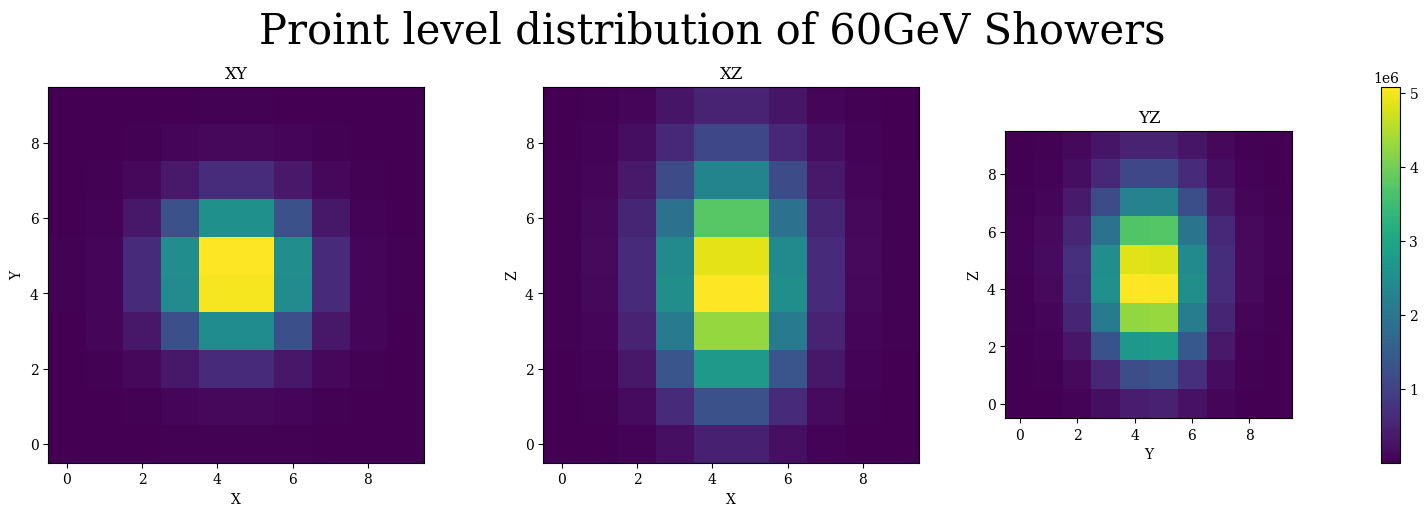

In [10]:
def get0Momentum(x, weights):

    out = (x*weights).sum(-1)
    return out/weights.sum(-1)

In [134]:
def plot_whole_shower_data(file_path):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
        #extracting the size of the showers
        size_of_event = len(data_showers[0])
        
        
        # Extract coordinates and energies
        x, y, z, energy_xyz = [data_showers[:, :, i] for i in range(4)]
        nonzero_mask = (energy_xyz != 0)

        
        energy_xyz_array = energy_xyz[nonzero_mask]
        
        
        # Plotting the distributions
        fig = plt.figure(figsize=(18, 12), facecolor='white')
        fig.suptitle(f'Shower level distributions [10-100]GeV', fontsize=30)
        gs = GridSpec(2, 3)

        # Energy Histogram
        ax0 = fig.add_subplot(gs[0])
        ax0.set_title('Visible Energy')
        ax0.hist(energy_xyz_array, bins=np.logspace(np.log(0.1), np.log(max(energy_xyz_array)), 150, base=np.e), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax0.set_xlabel('Visible energy (MeV)')
        ax0.set_ylabel('a.u.')
        ax0.set_xscale('log')
        ax0.set_yscale('log')

        # Energy Sum Histogram
        ax1 = fig.add_subplot(gs[1])
        ax1.set_title('Energy Sum')
        energy_of_event = energy_xyz.reshape(-1, size_of_event).sum(-1)
        ax1.hist(energy_of_event, bins=50, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax1.set_xlabel('Visible energy sum (MeV)')
        ax1.set_ylabel('a.u.')

        # Number of Hits Histogram
        ax2 = fig.add_subplot(gs[2])
        ax2.set_title('Number of Hits')
        n_hits = (energy_xyz != 0).reshape(-1, size_of_event).sum(axis=1)
        ax2.hist(n_hits, bins=40, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax2.set_xlabel('n_hits')
        ax2.set_ylabel('a.u.')

        
        # X Distribution
        
        x0 = get0Momentum(x,energy_xyz)
        average = sum(x0) / len(x0)
        ax3 = fig.add_subplot(gs[3])
        ax3.set_title('[X] distribution')
        ax3.hist(x0,bins = np.arange(average-average*0.05, average+average*0.05,0.005), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax3.set_xlabel('X')
        ax3.set_ylabel('a.u.')
        #ax3.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Y Distribution
        y0 = get0Momentum(y,energy_xyz)
        average = sum(y0) / len(y0)
        ax4 = fig.add_subplot(gs[4])
        ax4.set_title('[Y] distribution')
        ax4.hist(y0, bins = np.arange(average-average*0.05, average+average*0.05,0.005),  histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax4.set_xlabel('Y')
        ax4.set_ylabel('a.u.')
        #ax4.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Z Distribution
        z0 = get0Momentum(z,energy_xyz)
        average = sum(z0) / len(z0)
        ax5 = fig.add_subplot(gs[5])
        ax5.set_title('[Z] distribution')
        ax5.hist(z0, bins = np.arange(average-average*0.25, average+average*0.35,0.05),  histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax5.set_xlabel('Z')
        ax5.set_ylabel('a.u.')
        #ax5.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        fig.tight_layout()
        plt.show()
        fig.savefig(f'./plots/centerofmass_{size_of_event}_points.png')

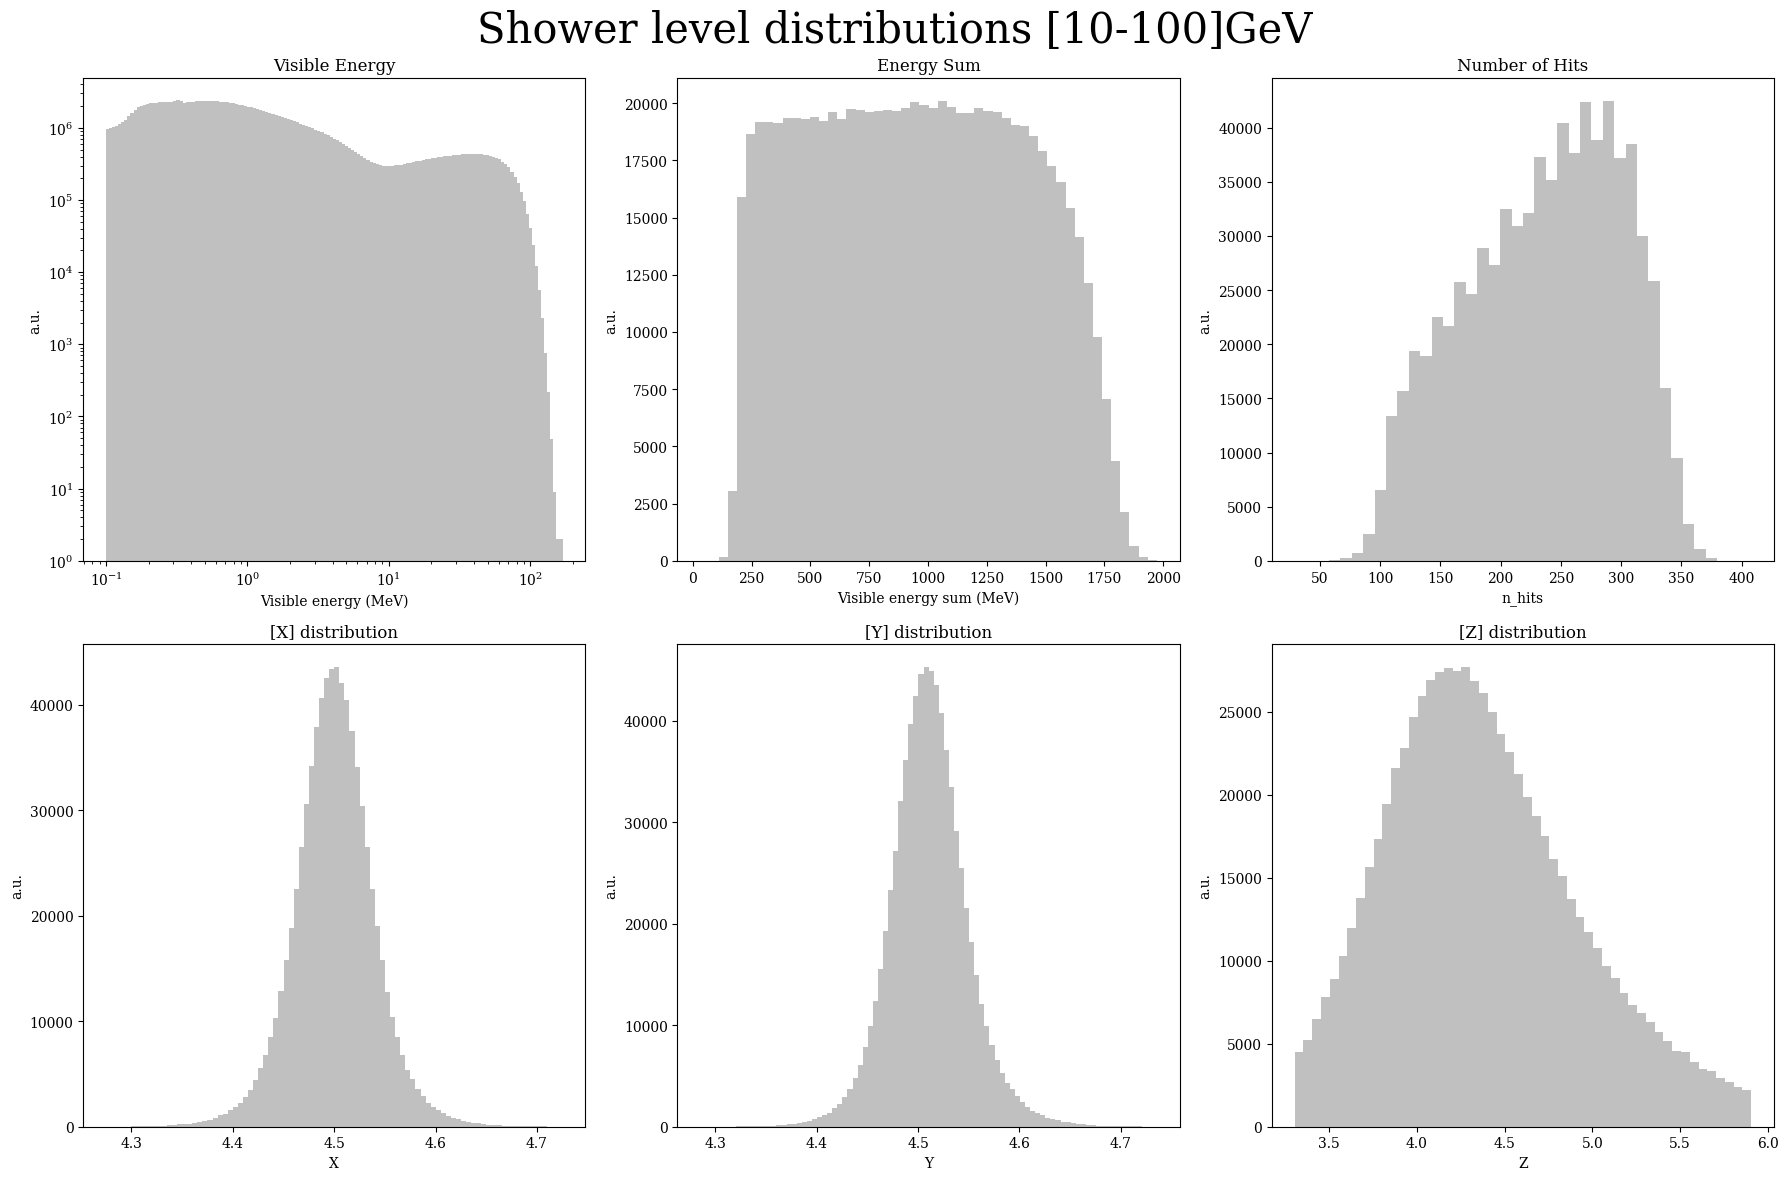

In [135]:
plot_whole_shower_data(file_path_500)

In [143]:
def plot_z_interaction_point(file_path):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
        #extracting the size of the showers
        size_of_event = len(data_showers[0])
        
        
        
        # Extract coordinates and energies
        x, y, z, energy_xyz = [data_showers[:, :, i] for i in range(4)]
        
        max_energy_indices = np.argmax(energy_xyz, axis=1)
        max_energy_z_values = z[np.arange(len(z)), max_energy_indices]
        
        xyz_bin_min = min(max_energy_z_values)
        xyz_bin_max = max(max_energy_z_values)+2
        
        # Create a new figure
        fig = plt.figure(figsize=(6, 6), facecolor='white')

        plt.title('z start layer')
        step =  math.ceil(xyz_bin_max/11)
        plt.hist(max_energy_z_values, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        plt.xlabel('z')
        plt.ylabel('a.u.')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0),useMathText=True)  # Set scientific notation for y-axis

        plt.xticks(np.arange(xyz_bin_min, xyz_bin_max, step))

        # Adjust layout to prevent labels from being cut off
        plt.tight_layout()

        # Show the plot
        plt.show()


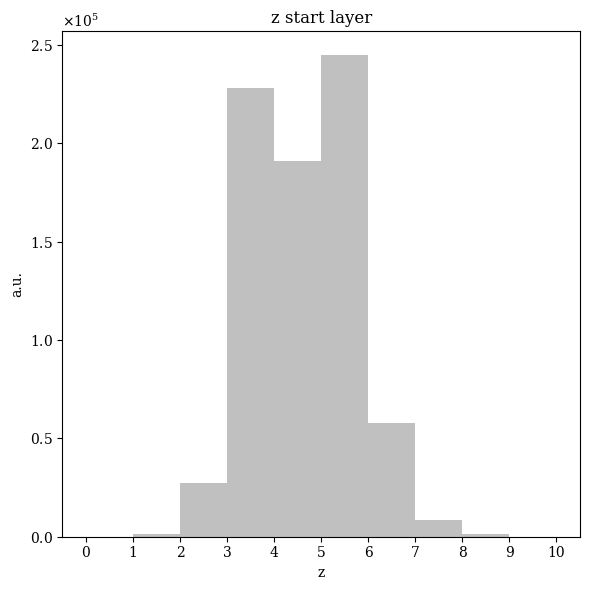

In [144]:
plot_z_interaction_point(file_path_500)